In [1]:
# Put these at the top of every notebook to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

General flow:

- import libraries
- set batch size
- set data path
- plot a sample data
- set image size
- select architecture
- set learner
- fit one cycle
- check the result

### Which libraries do we need?

In [2]:
# image processing & classification
from fastai.vision import *
# evaluation
from fastai.metrics import *

In [3]:
# Check GPU hardware is available
print(f'Cuda is available: {torch.cuda.is_available()}')
print(f'Cudnn backend enabled: {torch.backends.cudnn.enabled}')

Cuda is available: True
Cudnn backend enabled: True


---

### Set batch size

Set smaller size to prevent running out of GPU RAM

In [4]:
bs = 64

### Where is our data located?

For lesson 1, the dataset can be downloaded from `URLs.PETS`.

File size: 1.6GB

In [5]:
URLs.PETS

'https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet'

In [6]:
# Download and untar. Won't redownload if file already exists.
path = untar_data(URLs.PETS)
path

PosixPath('/home/paperspace/.fastai/data/oxford-iiit-pet')

In [7]:
# check the content
path.ls()

[PosixPath('/home/paperspace/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/home/paperspace/.fastai/data/oxford-iiit-pet/annotations')]

In [8]:
# list all files
fnames = get_image_files(path/'images')
fnames[:3]

[PosixPath('/home/paperspace/.fastai/data/oxford-iiit-pet/images/Bombay_70.jpg'),
 PosixPath('/home/paperspace/.fastai/data/oxford-iiit-pet/images/pug_169.jpg'),
 PosixPath('/home/paperspace/.fastai/data/oxford-iiit-pet/images/Ragdoll_96.jpg')]

Looks like the labels are in the file names. Use `regex` to extract them. Luckily, `fastai` has a data loader method that uses regex:

In [9]:
label_regex = r'/([^/]+)_\d+.jpg$'

Regex explanation (it is useful to start reading from the end):
- `/` forward slash, as part of path name. eg images`/`fname...
- `(...)` a group (matched text can be extracted for use later)
- `[]` a set of characters. eg `[a-z]`
- `^`  Matches the start of the string
- `[^/]+` Match all characters _except_ `/`
- `_\d+` underscore followed by 1 or more digits 0-9
- `.jpg` file extension
- `$` Matches the end of the string

In [10]:
# test the regex pattern
zz = re.compile(label_regex)
mo = zz.search('/Ragdoll_96.jpg')
mo

<re.Match object; span=(0, 15), match='/Ragdoll_96.jpg'>

In [11]:
mo.group(1)

'Ragdoll'

---

### Create a data bunch object

dont forget to set transformations, image size to use, and batch size.

and dont forget to normalize

In [21]:
# Since our dataset has labels in the file name
# we'd want to use from_name_re
data = ImageDataBunch.from_name_re(path=path/'images',
                                   fnames=fnames,
                                   pat=label_regex,
                                   ds_tfms=get_transforms(),
                                   size=224,
                                   bs=bs).normalize(imagenet_stats)

# by default, validation percentage is 0.2

```python
ImageDataBunch.from_csv
ImageDataBunch.from_df
ImageDataBunch.from_folder
ImageDataBunch.from_lists
ImageDataBunch.from_name_func
ImageDataBunch.from_name_re
```

In [26]:
# classes in our dataset
print(data.classes)
print(len(data.classes))

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']
37


### Show a few images

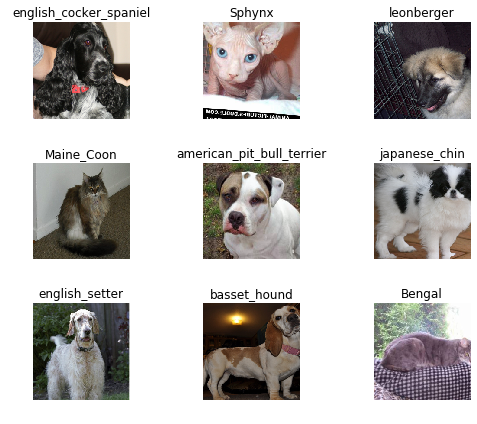

In [24]:
data.show_batch(rows=3, figsize=(7, 6))

---

### Create a `Learner` object

In [29]:
learn = create_cnn(data=data, arch=models.resnet34, metrics=error_rate)

In [31]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

### Fit one cycle

In [32]:
learn.fit_one_cycle(cyc_len=4) # 4 epochs per cycle

epoch,train_loss,valid_loss,error_rate
1,1.370603,0.314469,0.090663
2,0.556738,0.234536,0.077131
3,0.356137,0.205360,0.071719
4,0.263663,0.195941,0.067659


Note that `valid_loss` is larger than `train_loss`. This appears to be overfitting. But according to [Lesson 1 Discussion](https://forums.fast.ai/t/lesson-1-discussion/27332/515), it's not necessarily all bad

>as long as your validation metric is still improving.

In [33]:
# Save the current model weights
#learn.save('stage-1')

### Check the result

In [34]:
interp = ClassificationInterpretation.from_learner(learn=learn)

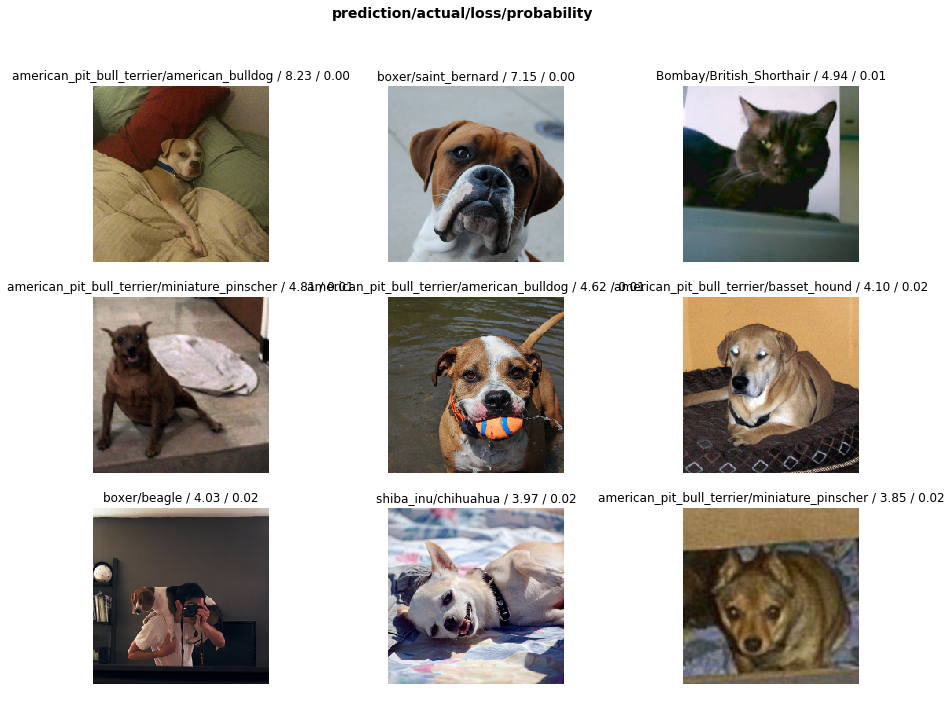

In [56]:
interp.plot_top_losses(k=9, figsize=(15,11))

In [57]:
interp.most_confused()

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Birman', 'Ragdoll', 5),
 ('Ragdoll', 'Birman', 5),
 ('american_bulldog', 'american_pit_bull_terrier', 5),
 ('Bengal', 'Egyptian_Mau', 4),
 ('Egyptian_Mau', 'Bengal', 4),
 ('miniature_pinscher', 'american_pit_bull_terrier', 4),
 ('Russian_Blue', 'British_Shorthair', 3),
 ('beagle', 'basset_hound', 3),
 ('boxer', 'american_bulldog', 3),
 ('miniature_pinscher', 'chihuahua', 3),
 ('Bengal', 'Abyssinian', 2),
 ('Birman', 'Siamese', 2),
 ('British_Shorthair', 'Russian_Blue', 2),
 ('american_bulldog', 'boxer', 2),
 ('chihuahua', 'miniature_pinscher', 2),
 ('english_cocker_spaniel', 'english_setter', 2),
 ('staffordshire_bull_terrier', 'american_bulldog', 2),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 2)]

Google the pictures of the most-confused breeds. See if you can do a better job spotting their differences!